In [ ]:
import pandas as pd

# **I. Introduction**

**A. Datasets**

**The first 3 data sets are FED economic data:** this is from Federal Reserve Bank Of St. Louis (FED) to show the economic conditions in the US.

* CPIAUCSL: **The US CPI** to measure the inflation, reported Monthly

*  RRVRUSQ156N: **The rental vacancy rate** to measure the percentage of rental properties that are vacant in the US, reported Quarterly

* MORTGAGE30US: **The mortgage interest rates** in the US , reported Weekly

**The last 2 data sets are Zillow price data**: this is from Zillow - a website provide data about real estate and homes for sale in US.

* Metro_median_sale_price_uc_sfrcondo_week: **The median sale price of houses** in US, reported Weekly

* Metro_zhvi_uc_sfrcondo_tier_0:  **The median value of all houses in US computed by Zillow**, reported Monthly

**B. Goal**
- Prediction will be the trend of houses price whether it goes up or down in the next reported period

# **II. Data Processing**

**A. Handle FED economic data**

Parse any dates in the csv file into pandas's date time and use first column as index

In [ ]:
fed_files = ["MORTGAGE30US.csv", "RRVRUSQ156N.csv", "CPIAUCSL.csv"]
dfs = [pd.read_csv(f, parse_dates=True, index_col=0) for f in fed_files]

**It can be seen that** 
* The mortgage interest rates is reported **Weekly**
* The rental vacancy rate is reported **Quarterly**
* The US CPI is reported **Monthly**

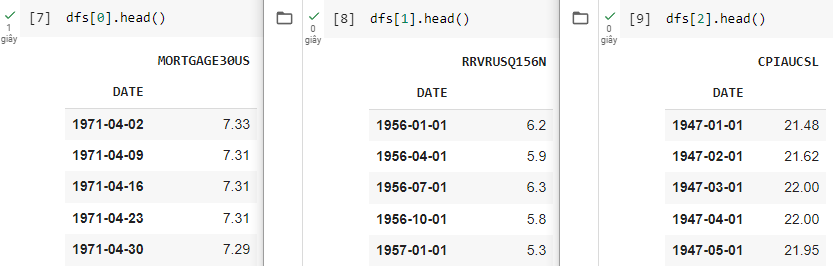

I will **Combine 3 dataframes to 1 big dataframe** and we can see NaN because those are reported in different time **(Weekly, Quarterly and Monthly)**

In [ ]:
fed_data = pd.concat(dfs, axis=1)
fed_data.tail(7)

,MORTGAGE30US,RRVRUSQ156N,CPIAUCSL
DATE,,,
2022-07-01,NaN,NaN,295.271
2022-07-07,5.30,NaN,NaN
2022-07-14,5.51,NaN,NaN
2022-07-21,5.54,NaN,NaN
2022-07-28,5.30,NaN,NaN
2022-08-04,4.99,NaN,NaN
2022-08-11,5.22,NaN,NaN


**To fix this issue,** I will assume that these rates are going to stay constant for the period in which they are released by using **forward filling**

For example, **the US CPI (3rd Column)** is released **Monthly** so I will assume that **295.271** will stay constant for the whole month **(July,2022)**

In [ ]:
fed_data= fed_data.ffill()
fed_data= fed_data.dropna()#drop missing value that dont have all 3 economic indicators
fed_data.tail(7)

,MORTGAGE30US,RRVRUSQ156N,CPIAUCSL
DATE,,,
2022-07-01,5.70,5.6,295.271
2022-07-07,5.30,5.6,295.271
2022-07-14,5.51,5.6,295.271
2022-07-21,5.54,5.6,295.271
2022-07-28,5.30,5.6,295.271
2022-08-04,4.99,5.6,295.271
2022-08-11,5.22,5.6,295.271


**B. Handle Zillow price data**

In [ ]:
zillow_files = ["Metro_median_sale_price_uc_sfrcondo_week.csv", "Metro_zhvi_uc_sfrcondo_tier_0.33_0.67_month.csv"]
dfs = [pd.read_csv(f) for f in zillow_files]

**In these 2 dataset**, we can see that
* Each rows is a region in the US
* Columns shows information about the region



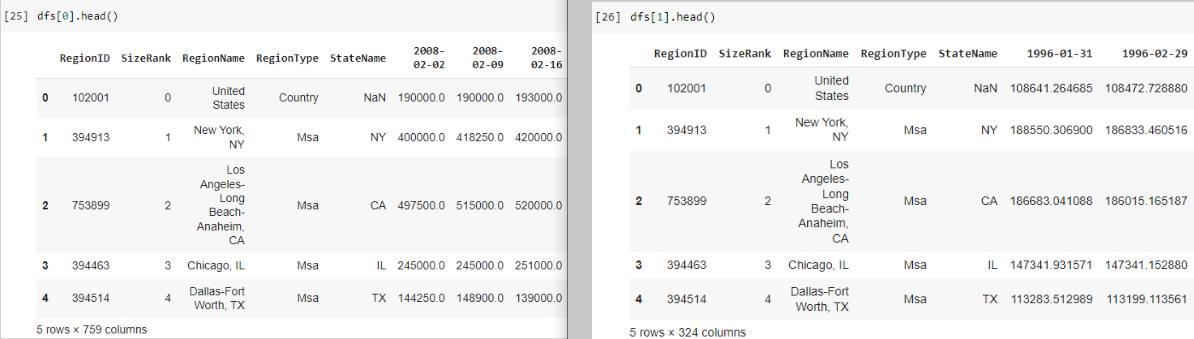

**In both 2 dataframes:**

* I will only **take the first row** because I only want to analyze data from the US 

* I also **remove these first 5 columns** to have only **The median sale price of house**, reported Weekly and **The house value computed by Zillow**, reported Monthly


In [ ]:
dfs = [pd.DataFrame(df.iloc[0,5:]) for df in dfs]
for df in dfs:
    df.index = pd.to_datetime(df.index)
    df["month"] = df.index.to_period("M")

**Because data in these 2 datatframe are report at different period** (Weekly and Monthly) so that I will add a column to both to merge them together using the common column.


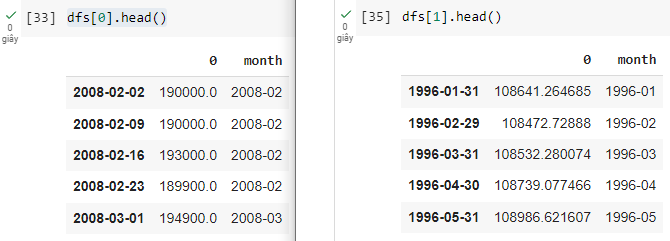

In [ ]:
price_data = dfs[0].merge(dfs[1], on="month") #merge using the common column
price_data.index = dfs[0].index #set index of this dataframe is the same as the index of the 1st dataframe
del price_data["month"] #Drop column month 
price_data.columns = ["price", "value"] #Change columns name
price_data

,price,value
2008-02-02,190000.0,206885.853266
2008-02-09,190000.0,206885.853266
2008-02-16,193000.0,206885.853266
2008-02-23,189900.0,206885.853266
2008-03-01,194900.0,205459.521952
...,...,...
2022-06-11,370000.0,357473.327397
2022-06-18,375000.0,357473.327397
2022-06-25,370000.0,357473.327397
2022-07-02,370000.0,357107.271636


In [ ]:
fed_data.tail(10)

In [ ]:
price_data.tail(10) 

**C.** Merge **Zillow** price data with **FED** economic data

**Because FED released its data 2 days sooner than Zillow,** so I am going to add a couple of days(shift forward) to align Fed data with Zillow data

In [ ]:
from datetime import timedelta
fed_data.index = fed_data.index + timedelta(days=2)

Now, I will merge **Zillow** price data with **FED** economic data

In [ ]:
price_data = fed_data.merge(price_data, left_index=True, right_index=True) 
#combine 2 df based on the matching of index which is the date in both df -> only took dates that matched in both df, anything that didnt match will be removed

In [ ]:
price_data.columns = ["Interest rate", "Vacancy rate", "CPI", "Median Sale Price", "House Value"] #rename columns
price_data

,Interest rate,Vacancy rate,CPI,Median Sale Price,House Value
2008-02-02,5.68,10.1,212.174,190000.0,206885.853266
2008-02-09,5.67,10.1,212.687,190000.0,206885.853266
2008-02-16,5.72,10.1,212.687,193000.0,206885.853266
2008-02-23,6.04,10.1,212.687,189900.0,206885.853266
2008-03-01,6.24,10.1,212.687,194900.0,205459.521952
...,...,...,...,...,...
2022-06-11,5.23,5.6,295.328,370000.0,357473.327397
2022-06-18,5.78,5.6,295.328,375000.0,357473.327397
2022-06-25,5.81,5.6,295.328,370000.0,357473.327397
2022-07-02,5.70,5.6,295.328,370000.0,357107.271636


**D. Data Visualization Overview**

<Axes: title={'center': 'Median Sale Price with Inflation'}>

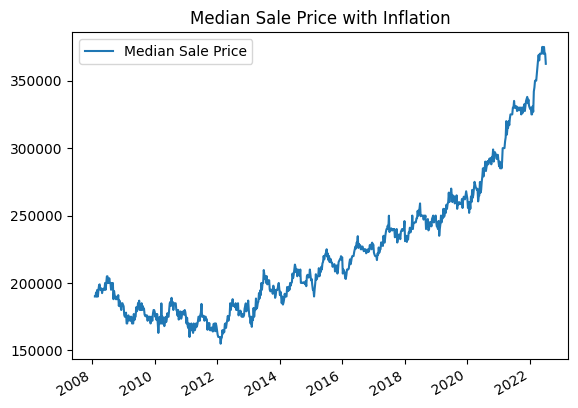

In [ ]:
price_data.plot.line(y="Median Sale Price", use_index=True, title='Median Sale Price with Inflation')

I will remove Inflation to know clearly about the increase in house prices (the Underlying house prices)

In [ ]:
price_data["adj_price"] = price_data["Median Sale Price"] / price_data["CPI"] * 100 #create an adjust price which is not affected by inflation
price_data["adj_value"] = price_data["House Value"] / price_data["CPI"] * 100 #create an adjust value which is not affected by inflation

<Axes: title={'center': 'Median Sale Price without Inflation'}>

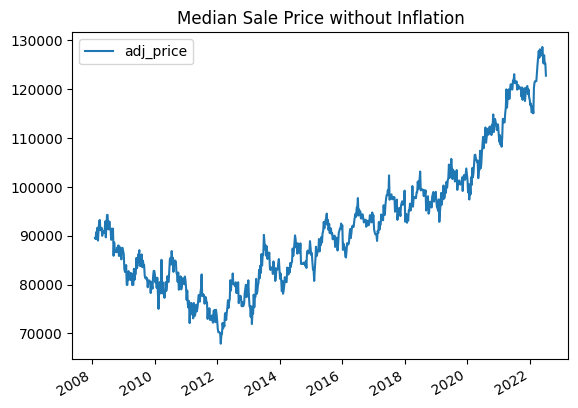

In [ ]:
price_data.plot.line(y="adj_price", use_index=True, title='Median Sale Price without Inflation')

# **III. Set up Target**

I will try to predict what will happen to house prices next Quarter **(go up or go down 3months from now)** by using pandas shift method

In [ ]:
price_data["next_quarter"] = price_data["adj_price"].shift(-13) 
#shift method will grabs the adjusted price into the future and pulls it back to the current row
price_data

,Interest rate,Vacancy rate,CPI,Median Sale Price,House Value,adj_price,adj_value,next_quarter
2008-02-02,5.68,10.1,212.174,190000.0,206885.853266,89549.143627,97507.636782,90610.014498
2008-02-09,5.67,10.1,212.687,190000.0,206885.853266,89333.151533,97272.448841,90563.547824
2008-02-16,5.72,10.1,212.687,193000.0,206885.853266,90743.674978,97272.448841,91014.739229
2008-02-23,6.04,10.1,212.687,189900.0,206885.853266,89286.134084,97272.448841,90610.014498
2008-03-01,6.24,10.1,212.687,194900.0,205459.521952,91637.006493,96601.824254,92933.348203
...,...,...,...,...,...,...,...,...
2022-06-11,5.23,5.6,295.328,370000.0,357473.327397,125284.429516,121042.815919,None
2022-06-18,5.78,5.6,295.328,375000.0,357473.327397,126977.462347,121042.815919,None
2022-06-25,5.81,5.6,295.328,370000.0,357473.327397,125284.429516,121042.815919,None
2022-07-02,5.70,5.6,295.328,370000.0,357107.271636,125284.429516,120918.867035,None


* Those rows that have NaN will be used to make predictions after building the model

* In order to train the algorithm, I have to actually know what happened so I could use these to make future predictions 

* Therefore, those rows can not be used for training data and I will drop them

In [ ]:
 price_data_need_to_predict = price_data.copy()
 save= price_data_need_to_predict.tail(13) #save data to predict later

In [ ]:
price_data_need_to_predict

,Interest rate,Vacancy rate,CPI,Median Sale Price,House Value,adj_price,adj_value,next_quarter
2008-02-02,5.68,10.1,212.174,190000.0,206885.853266,89549.143627,97507.636782,90610.014498
2008-02-09,5.67,10.1,212.687,190000.0,206885.853266,89333.151533,97272.448841,90563.547824
2008-02-16,5.72,10.1,212.687,193000.0,206885.853266,90743.674978,97272.448841,91014.739229
2008-02-23,6.04,10.1,212.687,189900.0,206885.853266,89286.134084,97272.448841,90610.014498
2008-03-01,6.24,10.1,212.687,194900.0,205459.521952,91637.006493,96601.824254,92933.348203
...,...,...,...,...,...,...,...,...
2022-06-11,5.23,5.6,295.328,370000.0,357473.327397,125284.429516,121042.815919,None
2022-06-18,5.78,5.6,295.328,375000.0,357473.327397,126977.462347,121042.815919,None
2022-06-25,5.81,5.6,295.328,370000.0,357473.327397,125284.429516,121042.815919,None
2022-07-02,5.70,5.6,295.328,370000.0,357107.271636,125284.429516,120918.867035,None


In [ ]:
save

,Interest rate,Vacancy rate,CPI,Median Sale Price,House Value,adj_price,adj_value,next_quarter
2022-04-16,5.00,5.6,288.663,369000.0,350515.841789,127830.723023,121427.353623,None
2022-04-23,5.11,5.6,288.663,365000.0,350515.841789,126445.024128,121427.353623,None
2022-04-30,5.10,5.6,288.663,370000.0,350515.841789,128177.147747,121427.353623,None
2022-05-07,5.27,5.6,291.474,369900.0,354717.722904,126906.688075,121697.895148,None
2022-05-14,5.30,5.6,291.474,370000.0,354717.722904,126940.996453,121697.895148,None
2022-05-21,5.25,5.6,291.474,370000.0,354717.722904,126940.996453,121697.895148,None
2022-05-28,5.10,5.6,291.474,375000.0,354717.722904,128656.415323,121697.895148,None
2022-06-04,5.09,5.6,295.328,375000.0,357473.327397,126977.462347,121042.815919,None
2022-06-11,5.23,5.6,295.328,370000.0,357473.327397,125284.429516,121042.815919,None
2022-06-18,5.78,5.6,295.328,375000.0,357473.327397,126977.462347,121042.815919,None


In [ ]:
price_data.dropna(inplace=True)#drop na value
price_data

,Interest rate,Vacancy rate,CPI,Median Sale Price,House Value,adj_price,adj_value,next_quarter
2008-02-02,5.68,10.1,212.174,190000.0,206885.853266,89549.143627,97507.636782,90610.014498
2008-02-09,5.67,10.1,212.687,190000.0,206885.853266,89333.151533,97272.448841,90563.547824
2008-02-16,5.72,10.1,212.687,193000.0,206885.853266,90743.674978,97272.448841,91014.739229
2008-02-23,6.04,10.1,212.687,189900.0,206885.853266,89286.134084,97272.448841,90610.014498
2008-03-01,6.24,10.1,212.687,194900.0,205459.521952,91637.006493,96601.824254,92933.348203
...,...,...,...,...,...,...,...,...
2022-03-12,3.85,5.8,287.708,350000.0,344042.433111,121651.118495,119580.419422,125284.429516
2022-03-19,4.16,5.8,287.708,350000.0,344042.433111,121651.118495,119580.419422,126977.462347
2022-03-26,4.42,5.8,287.708,355000.0,344042.433111,123388.991617,119580.419422,125284.429516
2022-04-02,4.67,5.8,287.708,360000.0,350515.841789,125126.864738,121830.412011,125284.429516


**I will add column 'Change' as a Target** to show whether the price go up or down in the next quarter

In [ ]:
price_data["change"] = (price_data["next_quarter"] > price_data["adj_price"]).astype(int)  #True =1, False=0 which means if the price goes up, change=1 and if the price goes down, change=0
#the column 'Change' will show the price 3 months from now is higher or lower than the current price in each row

In [ ]:
price_data

,Interest rate,Vacancy rate,CPI,Median Sale Price,House Value,adj_price,adj_value,next_quarter,change
2008-02-02,5.68,10.1,212.174,190000.0,206885.853266,89549.143627,97507.636782,90610.014498,1
2008-02-09,5.67,10.1,212.687,190000.0,206885.853266,89333.151533,97272.448841,90563.547824,1
2008-02-16,5.72,10.1,212.687,193000.0,206885.853266,90743.674978,97272.448841,91014.739229,1
2008-02-23,6.04,10.1,212.687,189900.0,206885.853266,89286.134084,97272.448841,90610.014498,1
2008-03-01,6.24,10.1,212.687,194900.0,205459.521952,91637.006493,96601.824254,92933.348203,1
...,...,...,...,...,...,...,...,...,...
2022-03-12,3.85,5.8,287.708,350000.0,344042.433111,121651.118495,119580.419422,125284.429516,1
2022-03-19,4.16,5.8,287.708,350000.0,344042.433111,121651.118495,119580.419422,126977.462347,1
2022-03-26,4.42,5.8,287.708,355000.0,344042.433111,123388.991617,119580.419422,125284.429516,1
2022-04-02,4.67,5.8,287.708,360000.0,350515.841789,125126.864738,121830.412011,125284.429516,1


Now I would want to know how many weeks did the price **go up** and how many weeks did the price **go down**

In [ ]:
price_data["change"].value_counts()

1    379
0    343
Name: change, dtype: int64

I will use variables (predictors) **to make prediction** and the target will be the 'Change' column  

In [ ]:
predictors = ["Interest rate", "Vacancy rate", "adj_price", "adj_value"] #use 4 columns to predict 1 column #features selection
target = "change"

# **IV. Build Model**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score 
#this will tell the accuracy percentage , when the model predicts the price would go up, how often did it go up and when the model predicts the price would go down how often did it go down
import numpy as np

**First I will create a prediction function**. This function will take in these inputs below and **return predictions**
* a training set 
* a test set which is what I want to make predictions on
* a set of predictor which are the columns I am going to use to make predictions
* a target

**Then I create a backtest function**. This function will let me generate predictions for most of my data set but do it in a way that
respects the order of the data set so that I can avoid using future data to predict the past





In [ ]:
START = 260 #start with 5 years of data, it will take all the data from 2008 to 2013 to predict 2014, then it will take all the data from 2008 to 2014 to predict 2015 and so on until I have  predictions for every year from 2014 through 2022 
STEP = 52 #52 weeks in 1 year

def predict(train, test, predictors, target):
    rf = RandomForestClassifier(min_samples_split=10, random_state=1) #min protects against overfitting by preventing the nodes in the decision trees in the random forest from splitting too deeply, a random state to ensure that every time I run my model it's going to generate the same sequence of random numbers, thereby giving the same result
    rf.fit(train[predictors], train[target]) #fit model using training data
    preds = rf.predict(test[predictors]) #generate predictions using test set
    return preds

def backtest(data, predictors, target):
    all_preds = [] #Create a list called all predictions
    for i in range(START, data.shape[0], STEP):
        train = price_data.iloc[:i] #everything up until i
        test = price_data.iloc[i:(i+STEP)] #the year following i
        all_preds.append(predict(train, test, predictors, target)) #append all of prediction sets to the list
    
    preds = np.concatenate(all_preds) #all predictions is going to be a list of numpy arrays (all_preds) -> concatenate those arrays together into a single array
    return preds, accuracy_score(data.iloc[START:][target], preds) # (data.iloc[START:][target]) are Actual values for test data vs (preds) Prediction values

In [ ]:
preds, accuracy = backtest(price_data, predictors, target) #run backtest to see how accurate
accuracy

0.5952380952380952

Now, it shows that I have **59%** accuracy in my predictions

# **V. Improve Model**

Now, I will need to add more variables into my model to give the model extra information 

I will **add new columns** to price_data to show the ratio for each variable between its current data and its average data in last year in each row, using rolling method

In [ ]:
yearly = price_data.rolling(52, min_periods=1).mean() #minimum periods =1 means that even if I have 1 period of data, pandas won't return a NaN. For example, pandas has less than 52 weeks of data (2008) from the current row backwards it'll return an Nan but min periods avoids that

In [ ]:
yearly

,Interest rate,Vacancy rate,CPI,Median Sale Price,House Value,adj_price,adj_value,next_quarter,change
2008-02-02,5.680000,10.100000,212.174000,190000.000000,206885.853266,89549.143627,97507.636782,90610.014498,1.000000
2008-02-09,5.675000,10.100000,212.430500,190000.000000,206885.853266,89441.147580,97390.042811,90586.781161,1.000000
2008-02-16,5.690000,10.100000,212.516000,191000.000000,206885.853266,89875.323379,97350.844821,90729.433850,1.000000
2008-02-23,5.777500,10.100000,212.558750,190725.000000,206885.853266,89728.026056,97331.245826,90699.579012,1.000000
2008-03-01,5.870000,10.100000,212.584400,191560.000000,206600.587003,90109.822143,97185.361512,91146.332850,1.000000
...,...,...,...,...,...,...,...,...,...
2022-03-12,3.115000,5.934615,274.619904,327174.057692,313200.591987,119132.562983,113969.580920,121263.755243,0.576923
2022-03-19,3.136923,5.915385,275.056058,328135.596154,314338.764087,119295.169360,114202.242187,121398.973432,0.576923
2022-03-26,3.163269,5.896154,275.492212,329193.288462,315476.936188,119491.196374,114434.903454,121501.633298,0.576923
2022-04-02,3.193654,5.876923,275.928365,330250.980769,316739.596917,119684.363389,114710.833809,121568.806147,0.576923


Now, **the values in 'yearly'** are actually the average of Interest rate, average of Vacancy rate, average of CPI, average of Median Sale Price and average of	House Value, average of adj_price and average of adj_value for the past year

**For example,** in 'yearly', those figures in 2022-04-09 are actually the average of those in 2021

Then I will find the ratio between the current value and the value in the past year to see how the price trending

In [ ]:
yearly_ratios = [p + '_year' for p in predictors] #define columns names -> Interest rate_year, Vacancy rate_year,...
price_data[yearly_ratios] = price_data[predictors] / yearly[predictors] #add new columns and lấy data ở các column Interest rate,... trong df price_data (data hiện tại) chia cho data ở các column Interest rate trong df yearly (data past year) để ratio-> xem tăng hay giảm so với năm trước

In [ ]:
price_data

,Interest rate,Vacancy rate,CPI,Median Sale Price,House Value,adj_price,adj_value,next_quarter,change,Interest rate_year,Vacancy rate_year,adj_price_year,adj_value_year
2008-02-02,5.68,10.1,212.174,190000.0,206885.853266,89549.143627,97507.636782,90610.014498,1,1.000000,1.000000,1.0,1.0
2008-02-09,5.67,10.1,212.687,190000.0,206885.853266,89333.151533,97272.448841,90563.547824,1,0.999119,1.000000,0.998793,0.998793
2008-02-16,5.72,10.1,212.687,193000.0,206885.853266,90743.674978,97272.448841,91014.739229,1,1.005272,1.000000,1.009662,0.999195
2008-02-23,6.04,10.1,212.687,189900.0,206885.853266,89286.134084,97272.448841,90610.014498,1,1.045435,1.000000,0.995075,0.999396
2008-03-01,6.24,10.1,212.687,194900.0,205459.521952,91637.006493,96601.824254,92933.348203,1,1.063032,1.000000,1.016948,0.993996
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-12,3.85,5.8,287.708,350000.0,344042.433111,121651.118495,119580.419422,125284.429516,1,1.235955,0.977317,1.021141,1.049231
2022-03-19,4.16,5.8,287.708,350000.0,344042.433111,121651.118495,119580.419422,126977.462347,1,1.326140,0.980494,1.019749,1.047093
2022-03-26,4.42,5.8,287.708,355000.0,344042.433111,123388.991617,119580.419422,125284.429516,1,1.397289,0.983692,1.03262,1.044965
2022-04-02,4.67,5.8,287.708,360000.0,350515.841789,125126.864738,121830.412011,125284.429516,1,1.462275,0.986911,1.045474,1.062065


**For example:** In 2022-04-09, Interest rate_year = 1.4 which mean the Interest rate in 2022-04-09 has increased **(Interest rate in 2022-04-09 = 1.4* Interest rate in 2021-04-09)**

Check again if the whether accuracy improved or not with new variable (yearly_ratios)

In [ ]:
preds, accuracy = backtest(price_data, predictors + yearly_ratios, target)

In [ ]:
preds

In [ ]:
accuracy

0.6536796536796536

**Now, it shows that I have 65% accuracy in my predictions**. This means adding in these ratios has given the algorithm good information that it can use to make better decisions

# **VI. Future value prediction**

After part V, I know that **adding more ratios will bring predictions with a higher accuracy rate** (65%). Therefore, I will make a new dataframe called **price_data_need_to_predict** which is the same as original dataset (**price_data**) but then I will add 4 new variables to **price_data_need_to_predict**

In [ ]:
yearly = price_data_need_to_predict.rolling(52, min_periods=1).mean() 
yearly_ratios = [p + '_year' for p in predictors] #define columns names -> Interest rate_year, Vacancy rate_year,...
price_data_need_to_predict[yearly_ratios] = price_data_need_to_predict[predictors] / yearly[predictors] #lấy data ở các column Interest rate,... trong df price_data (data hiện tại) chia cho data ở các column Interest rate trong df yearly (data past year) để ratio-> xem tăng hay giảm so với năm trước

Now, we can see that the new dataframe has **more variables than** the old one

* **Old:** price_data (7 variables: Interest rate,	Vacancy rate,	CPI	Median Sale Price,	House Value,	adj_price,	adj_value)

* **New:** price_data_need_to_predict (11 variables= 7 old variables + 4 new variables: Interest rate_year, Vacancy rate_year, adj_price_year, adj_value_year)

In [ ]:
price_data_need_to_predict

,Interest rate,Vacancy rate,CPI,Median Sale Price,House Value,adj_price,adj_value,next_quarter,Interest rate_year,Vacancy rate_year,adj_price_year,adj_value_year
2008-02-02,5.68,10.1,212.174,190000.0,206885.853266,89549.143627,97507.636782,90610.014498,1.000000,1.000000,1.0,1.0
2008-02-09,5.67,10.1,212.687,190000.0,206885.853266,89333.151533,97272.448841,90563.547824,0.999119,1.000000,0.998793,0.998793
2008-02-16,5.72,10.1,212.687,193000.0,206885.853266,90743.674978,97272.448841,91014.739229,1.005272,1.000000,1.009662,0.999195
2008-02-23,6.04,10.1,212.687,189900.0,206885.853266,89286.134084,97272.448841,90610.014498,1.045435,1.000000,0.995075,0.999396
2008-03-01,6.24,10.1,212.687,194900.0,205459.521952,91637.006493,96601.824254,92933.348203,1.063032,1.000000,1.016948,0.993996
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-11,5.23,5.6,295.328,370000.0,357473.327397,125284.429516,121042.815919,None,1.454954,0.973913,1.033156,1.034353
2022-06-18,5.78,5.6,295.328,375000.0,357473.327397,126977.462347,121042.815919,None,1.584313,0.975871,1.045952,1.032768
2022-06-25,5.81,5.6,295.328,370000.0,357473.327397,125284.429516,121042.815919,None,1.568966,0.977837,1.031134,1.031188
2022-07-02,5.70,5.6,295.328,370000.0,357107.271636,125284.429516,120918.867035,None,1.517432,0.979812,1.030564,1.02858


In [ ]:
new_price_data_need_to_predict = price_data_need_to_predict.copy() #make copy
new_save= new_price_data_need_to_predict.tail(13) #save data to predict later

I will drop rows in **price_data_need_to_predict** with null value in column 'next quarter' because next quarter of those days have not happenend yet (which means the future)

In [ ]:
price_data_need_to_predict.dropna(inplace=True)#drop na value
price_data_need_to_predict["change"] = (price_data_need_to_predict["next_quarter"] > price_data_need_to_predict["adj_price"]).astype(int) 

In [ ]:
price_data_need_to_predict

,Interest rate,Vacancy rate,CPI,Median Sale Price,House Value,adj_price,adj_value,next_quarter,Interest rate_year,Vacancy rate_year,adj_price_year,adj_value_year,change
2008-02-02,5.68,10.1,212.174,190000.0,206885.853266,89549.143627,97507.636782,90610.014498,1.000000,1.000000,1.0,1.0,1
2008-02-09,5.67,10.1,212.687,190000.0,206885.853266,89333.151533,97272.448841,90563.547824,0.999119,1.000000,0.998793,0.998793,1
2008-02-16,5.72,10.1,212.687,193000.0,206885.853266,90743.674978,97272.448841,91014.739229,1.005272,1.000000,1.009662,0.999195,1
2008-02-23,6.04,10.1,212.687,189900.0,206885.853266,89286.134084,97272.448841,90610.014498,1.045435,1.000000,0.995075,0.999396,1
2008-03-01,6.24,10.1,212.687,194900.0,205459.521952,91637.006493,96601.824254,92933.348203,1.063032,1.000000,1.016948,0.993996,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-12,3.85,5.8,287.708,350000.0,344042.433111,121651.118495,119580.419422,125284.429516,1.235955,0.977317,1.021141,1.049231,1
2022-03-19,4.16,5.8,287.708,350000.0,344042.433111,121651.118495,119580.419422,126977.462347,1.326140,0.980494,1.019749,1.047093,1
2022-03-26,4.42,5.8,287.708,355000.0,344042.433111,123388.991617,119580.419422,125284.429516,1.397289,0.983692,1.03262,1.044965,1
2022-04-02,4.67,5.8,287.708,360000.0,350515.841789,125126.864738,121830.412011,125284.429516,1.462275,0.986911,1.045474,1.062065,1


Now, I will have **8 predictors** because part V show that add those 4 variables would improve the chance of accuracy predictions

In [ ]:
predictors = ['Interest rate', 'Vacancy rate', 'adj_price', 'adj_value', 'Interest rate_year'	,'Vacancy rate_year'	,'adj_price_year',	'adj_value_year']
def improved_predict(train, test, predictors, target):
    rf = RandomForestClassifier(min_samples_split=10, random_state=1) #min protects against overfitting by preventing the nodes in the decision trees in the random forest from splitting too deeply, a random state to ensure that every time I run my model it's going to generate the same sequence of random numbers, thereby giving the same result
    rf.fit(train[predictors], train[target]) #fit model using training data
    preds = rf.predict(test[predictors]) #generate predictions using test set
    return preds

def backtest(data, predictors, target):
    all_preds = [] #Create a list called all predictions
    for i in range(START, data.shape[0], STEP):
        train = price_data_need_to_predict.iloc[:i] #everything up until i
        test = price_data_need_to_predict.iloc[i:(i+STEP)] #the year following i
        all_preds.append(predict(train, test, predictors, target)) #append all of prediction sets to the list
    
    preds = np.concatenate(all_preds) #all predictions is going to be a list of numpy arrays (all_preds) -> concatenate those arrays together into a single array
    return preds, accuracy_score(data.iloc[START:][target], preds) # (data.iloc[START:][target]) are Actual values for test data vs (preds) Prediction values


Then, I have a new model which use **8 factors** to predict the 'Change'(trend of house price) with the function call ỉmproved_predict

Now, I will run the model with: 
* **price_data_need_to_predict as training set:** because this new dataframe now includes 8 factors

* **new_save as test set:**  because this is the dataset contain rows that have null values of next quarter from 2022-04-16 to 2022-07-09 thereby it wil be use to predict future value after model is trained

* **K as future value:** this will be the prediction for next quarter from 2022-04-16 to 2022-07-09 (would be houses price trend from 2022-07-16 to 2022-10-09)

In [ ]:
K = improved_predict(price_data_need_to_predict,new_save,predictors, target)
K

array([0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [ ]:
new_save['change'] = K
new_save #future data with predict

<ipython-input-361-d1312036325d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_save['change'] = K


,Interest rate,Vacancy rate,CPI,Median Sale Price,House Value,adj_price,adj_value,next_quarter,Interest rate_year,Vacancy rate_year,adj_price_year,adj_value_year,change
2022-04-16,5.00,5.6,288.663,369000.0,350515.841789,127830.723023,121427.353623,None,1.534466,0.958525,1.06497,1.053828,0
2022-04-23,5.11,5.6,288.663,365000.0,350515.841789,126445.024128,121427.353623,None,1.550111,0.960422,1.051703,1.051583,1
2022-04-30,5.10,5.6,288.663,370000.0,350515.841789,128177.147747,121427.353623,None,1.528706,0.962327,1.064394,1.049348,0
2022-05-07,5.27,5.6,291.474,369900.0,354717.722904,126906.688075,121697.895148,None,1.558994,0.964238,1.052364,1.049408,1
2022-05-14,5.30,5.6,291.474,370000.0,354717.722904,126940.996453,121697.895148,None,1.547445,0.966158,1.05148,1.047564,1
2022-05-21,5.25,5.6,291.474,370000.0,354717.722904,126940.996453,121697.895148,None,1.513388,0.968085,1.049988,1.045594,1
2022-05-28,5.10,5.6,291.474,375000.0,354717.722904,128656.415323,121697.895148,None,1.452753,0.970020,1.062693,1.043631,1
2022-06-04,5.09,5.6,295.328,375000.0,357473.327397,126977.462347,121042.815919,None,1.433492,0.971963,1.04783,1.03618,1
2022-06-11,5.23,5.6,295.328,370000.0,357473.327397,125284.429516,121042.815919,None,1.454954,0.973913,1.033156,1.034353,1
2022-06-18,5.78,5.6,295.328,375000.0,357473.327397,126977.462347,121042.815919,None,1.584313,0.975871,1.045952,1.032768,1


Now, the value in 'Change' column will show the **future trends of house prices**

**For example:** 

**In 2022-04-16,** change = 0

* This means: the price of next quarter **(on this day 3 months later)** < adj price **(on this day)**

* Which also mean: adj price of **2022-07-16** (future) < adj price of **2022-04-16** (present)

**In 2022-06-25,** change = 1

* This means: the price of next quarter **(on this day 3 months later)** > adj price **(on this day)**

* Which also mean: adj price of **2022-09-25** (future) > adj price of **2022-06-25** (present)

**Finally,** I will test this model accuracy again to see if the idea of adding more variable could bring more percentage of accuracy as it shows before **in part V**

In [ ]:
preds, accuracy = backtest(price_data_need_to_predict, predictors, target) #run backtest to see how accurate the model with new data includes 8 factors
accuracy

0.6536796536796536

**In conclusion,** I have more than **65%** accurate for my future prediction from 2022-04-16 to 2022-07-09.

**Visualize** the predictions in **price_data_need_to_predict**


In [ ]:
pred_match = (preds == price_data_need_to_predict[target].iloc[START:])
pred_match[pred_match == True] = "green" #True if it predict 1 and the next quarter price actual > adj price and  or it predict 0 and the next quarter price actually < adj price 
pred_match[pred_match == False] = "red" #False if it predict 1 and the next quarter price actual < adj price and  or it predict 0 and the next quarter price actually > adj price 

<Axes: xlabel='index', ylabel='adj_price'>

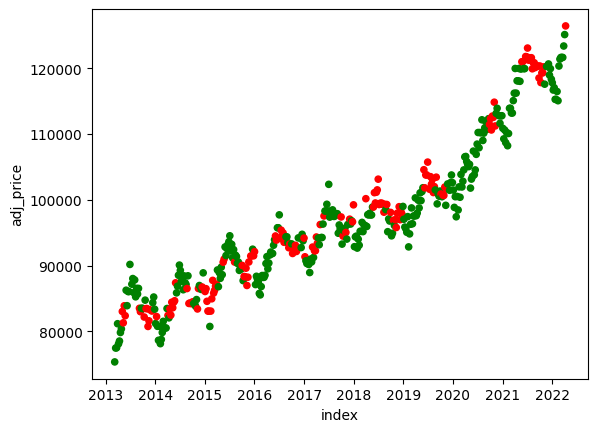

In [ ]:
import matplotlib.pyplot as plt

plot_data = price_data_need_to_predict.iloc[START:].copy()

plot_data.reset_index().plot.scatter(x="index", y="adj_price", color=pred_match)

**The graph above shows that** when the house price is in uptrend, the model tends to provide more accurate predictions

# **VII. Ideas to improve the model** 

Adding in more predictors that explain when the market is about to
shift like news articles or other economic data sets, economic indicators, stock market indicators, gold price, place information where new house is being built, criminal rate, etc could help improve this model.